In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from mnist_skeptic_v9 import skeptic_v9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_folder = 'composite_image_folders'

In [2]:
# Cell 2: Model Definition and Loading
class EnsembleModel(nn.Module):
    def __init__(self, model_paths):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([skeptic_v9() for _ in range(len(model_paths))])
        for model, path in zip(self.models, model_paths):
            model.load_state_dict(torch.load(path))
            model.eval()

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

def create_ensemble(model_dir='best_boi_models'):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
    return EnsembleModel(model_paths)

def load_ensemble(model_path):
    state_dict = torch.load(model_path)
    model = create_ensemble()
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [3]:
# Function to invert the MNIST images (black digits on white background)
def invert_image(image):
    return 1 - image

# Cell 3: Data Loading Functions
def load_mnist_test_data():
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(invert_image)  # Use invert_image function instead of lambda
    ])
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(test_dataset, batch_size=64, shuffle=False)

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) #PLEASE CHANGE THIS TO THE TRAINING NORMALIZATION VALUES (0.1307,), (0.3081,) IF YOU WANT TO USE THE TRAINING NORMALIZATION VALUES - ELSE (0.5,), (0.5,) WILL BE USED
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class CompositeDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        image = self.transform(image)
        return image, self.labels[idx]

def load_composite_data(base_folder):
    standard_images, standard_labels = [], []
    rotated_images, rotated_labels = [], []
    cursive_images, cursive_labels = [], []

    for folder in os.listdir(base_folder):
        if folder.startswith('composite_images_'):
            folder_path = os.path.join(base_folder, folder)
            for filename in os.listdir(folder_path):
                if filename.endswith('.png'):
                    file_path = os.path.join(folder_path, filename)
                    digit = int(filename.split('_')[2].split('.')[0])
                    
                    if 'cursive' in filename:
                        cursive_images.append(file_path)
                        cursive_labels.append(digit)
                    elif 'angle' in filename:
                        rotated_images.append(file_path)
                        rotated_labels.append(digit)
                    else:
                        standard_images.append(file_path)
                        standard_labels.append(digit)

    return (
        CompositeDataset(standard_images, standard_labels),
        CompositeDataset(rotated_images, rotated_labels),
        CompositeDataset(cursive_images, cursive_labels)
    )

In [4]:
# Cell 4: Evaluation Functions
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def analyze_confusion(cm):
    n_classes = cm.shape[0]
    
    # Most confusable pairs
    confusable_pairs = []
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            if i != j:
                confusion_score = cm[i, j] + cm[j, i]
                confusable_pairs.append((i, j, confusion_score))
    
    confusable_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Most discriminable digits
    discriminability = np.diag(cm) / cm.sum(axis=1)
    most_discriminable = np.argsort(discriminability)[::-1]
    
    # Digits the model always guesses (overfitting)
    guess_bias = cm.sum(axis=0) / cm.sum()
    most_guessed = np.argsort(guess_bias)[::-1]
    
    return confusable_pairs[:5], most_discriminable[:5], most_guessed[:5]

def calculate_confusability_scores(cm):
    n_classes = cm.shape[0]
    confusability_scores = {}
    
    for digit in range(n_classes):
        # Sum of cases where this digit was confused for another
        confused_for_others = cm[digit, :].sum() - cm[digit, digit]
        
        # Sum of cases where other digits were confused for this one
        others_confused_for_this = cm[:, digit].sum() - cm[digit, digit]
        
        # Total confusability score
        total_confusions = confused_for_others + others_confused_for_this
        
        # Normalize by the total number of true instances of this digit
        confusability_score = total_confusions / cm[digit, :].sum()
        
        confusability_scores[digit] = confusability_score
    
    # Sort digits by confusability score in descending order
    sorted_scores = sorted(confusability_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_scores

In [8]:
# Cell 5: Main Evaluation Functions
def main_evaluation(model):
    # Evaluate on MNIST
    mnist_loader = load_mnist_test_data()
    mnist_preds, mnist_labels = evaluate_model(model, mnist_loader)
    plot_confusion_matrix(mnist_labels, mnist_preds, "MNIST Confusion Matrix")
    
    # Analyze MNIST results
    mnist_cm = confusion_matrix(mnist_labels, mnist_preds)
    mnist_confusable, mnist_discriminable, mnist_guessed = analyze_confusion(mnist_cm)
    mnist_confusability_scores = calculate_confusability_scores(mnist_cm)
    
    print("MNIST Analysis:")
    print("Accuracy:", np.mean(mnist_preds == mnist_labels))
    print("Most confusable pairs:", mnist_confusable)
    print("Most discriminable digits:", mnist_discriminable)
    print("Most frequently guessed digits:", mnist_guessed)
    print("Confusability scores:", mnist_confusability_scores)
    
    # Evaluate on Experimental Data
    exp_data = load_all_experimental_data('test_digits')
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, participant_data = exp_data
    
    exp_dataset = ExperimentalDataset(exp_test_images, exp_test_labels)
    exp_loader = DataLoader(exp_dataset, batch_size=64, shuffle=False)
    
    exp_preds, exp_labels = evaluate_model(model, exp_loader)
    plot_confusion_matrix(exp_labels, exp_preds, "Experimental Data Confusion Matrix")
    
    # Analyze Experimental results
    exp_cm = confusion_matrix(exp_labels, exp_preds)
    exp_confusable, exp_discriminable, exp_guessed = analyze_confusion(exp_cm)
    exp_confusability_scores = calculate_confusability_scores(exp_cm)
    
    print("\nExperimental Data Analysis:")
    print("Accuracy:", np.mean(exp_preds == exp_labels))
    print("Most confusable pairs:", exp_confusable)
    print("Most discriminable digits:", exp_discriminable)
    print("Most frequently guessed digits:", exp_guessed)
    print("Confusability scores:", exp_confusability_scores)

def analyze_composite_data(model, base_folder):
    standard_dataset, rotated_dataset, cursive_dataset = load_composite_data(base_folder)

    for name, dataset in [("Standard", standard_dataset), ("Rotated", rotated_dataset), ("Cursive", cursive_dataset)]:
        preds, labels = evaluate_model(model, DataLoader(dataset, batch_size=32, shuffle=False))
        
        print(f"\n{name} Composite Images Analysis:")
        print(f"Accuracy: {np.mean(preds == labels):.4f}")
        
        plot_confusion_matrix(labels, preds, f"{name} Composite Confusion Matrix")
        
        cm = confusion_matrix(labels, preds)
        confusability_scores = calculate_confusability_scores(cm)
        print("Confusability scores (digit: score):")
        for digit, score in confusability_scores:
            print(f"  {digit}: {score:.4f}")

C:\Users\Sai\AppData\Local\Temp\ipykernel_32604\3548712547.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
C:\Users\Sai\AppData\Loca

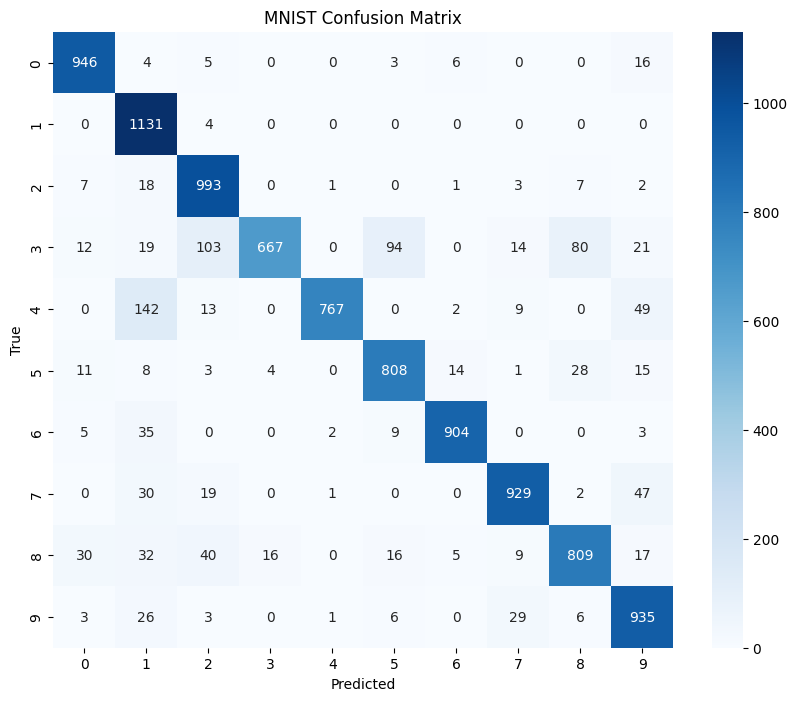

MNIST Analysis:
Accuracy: 0.8889
Most confusable pairs: [(1, 4, 142), (2, 3, 103), (3, 5, 98), (3, 8, 96), (7, 9, 76)]
Most discriminable digits: [1 0 2 6 9]
Most frequently guessed digits: [1 2 9 0 7]
Confusability scores: [(3, 0.3594059405940594), (8, 0.29568788501026694), (1, 0.2801762114537445), (9, 0.24182358771060455), (5, 0.23766816143497757), (4, 0.2240325865580448), (2, 0.22189922480620156), (7, 0.15953307392996108), (0, 0.10408163265306122), (6, 0.08559498956158663)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Par

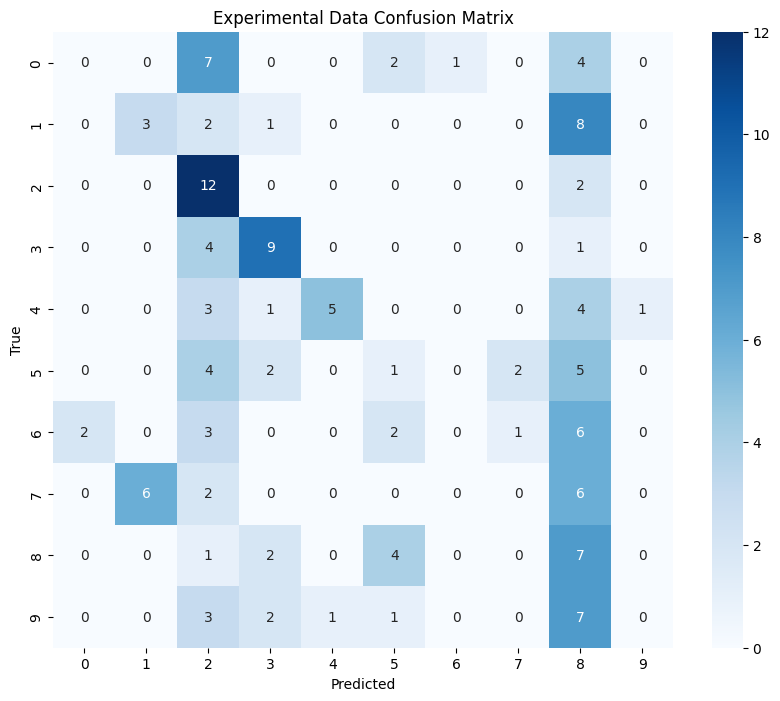


Experimental Data Analysis:
Accuracy: 0.2642857142857143
Most confusable pairs: [(5, 8, 9), (1, 8, 8), (0, 2, 7), (8, 9, 7), (1, 7, 6)]
Most discriminable digits: [2 3 8 4 1]
Most frequently guessed digits: [8 2 3 5 1]
Confusability scores: [(8, 3.5714285714285716), (2, 2.2142857142857144), (5, 1.5714285714285714), (1, 1.2142857142857142), (7, 1.2142857142857142), (0, 1.1428571428571428), (6, 1.0714285714285714), (9, 1.0714285714285714), (3, 0.9285714285714286), (4, 0.7142857142857143)]

Standard Composite Images Analysis:
Accuracy: 0.4500


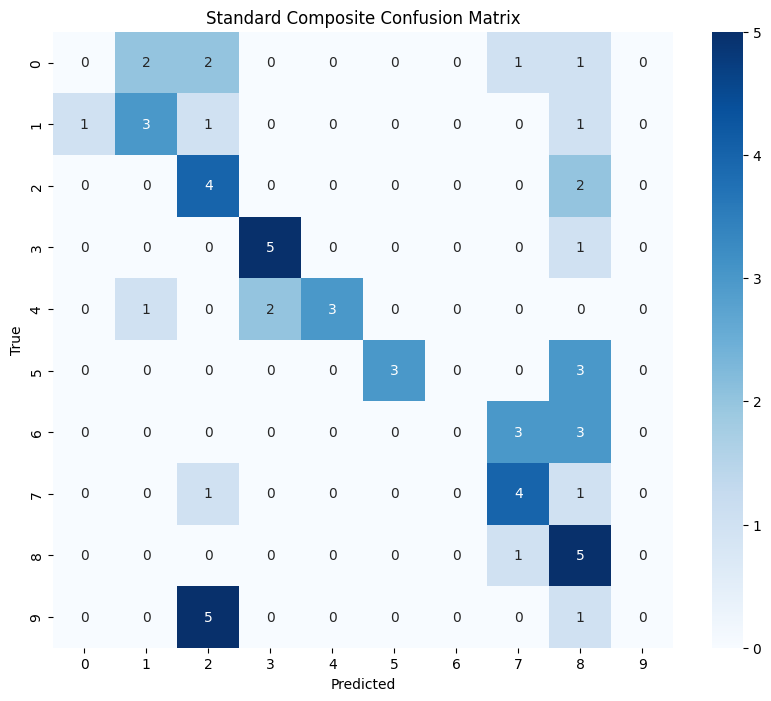

Confusability scores (digit: score):
  8: 2.3333
  2: 1.8333
  0: 1.1667
  7: 1.1667
  1: 1.0000
  6: 1.0000
  9: 1.0000
  3: 0.5000
  4: 0.5000
  5: 0.5000

Rotated Composite Images Analysis:
Accuracy: 0.1389


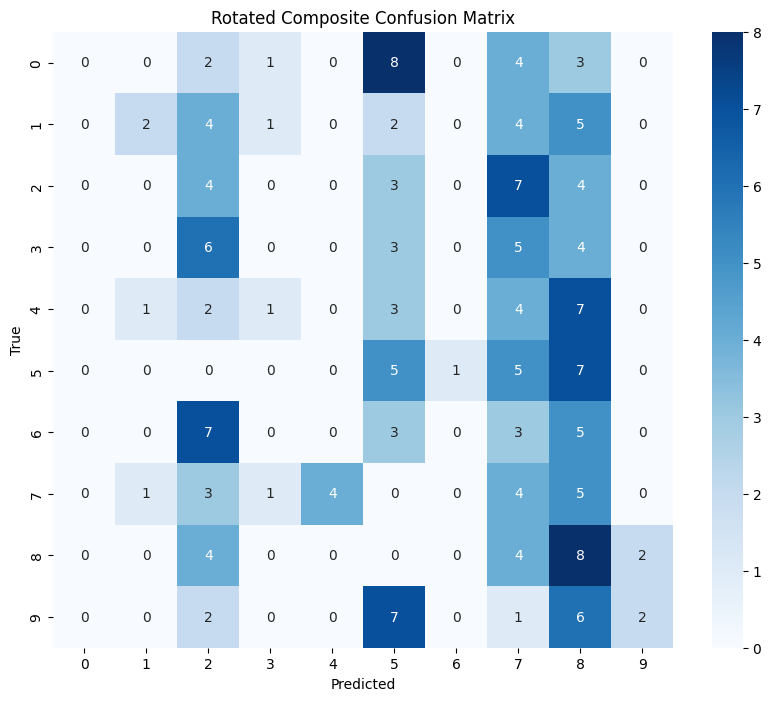

Confusability scores (digit: score):
  8: 3.1111
  7: 2.8333
  2: 2.4444
  5: 2.3333
  3: 1.2222
  4: 1.2222
  6: 1.0556
  0: 1.0000
  1: 1.0000
  9: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.3000


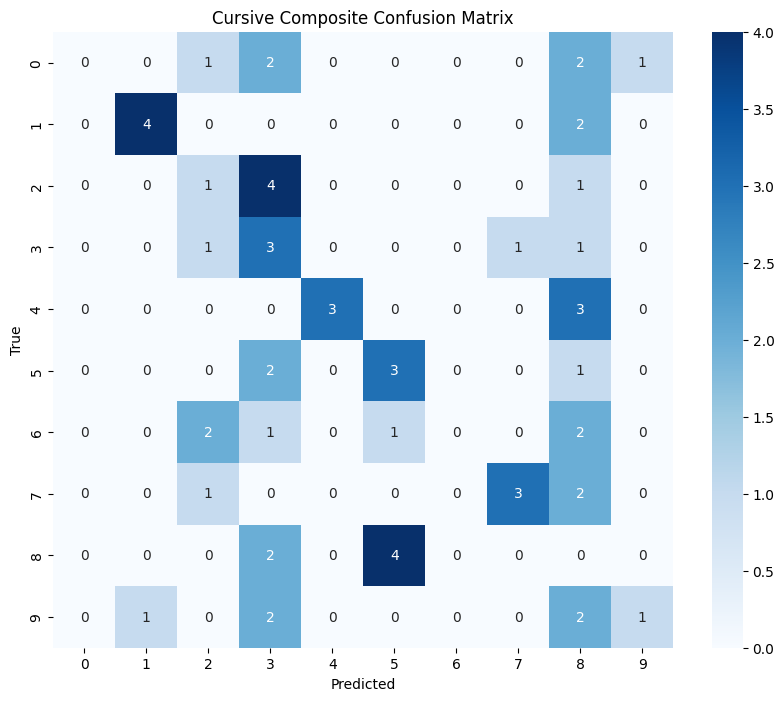

Confusability scores (digit: score):
  8: 3.6667
  3: 2.6667
  2: 1.6667
  5: 1.3333
  0: 1.0000
  6: 1.0000
  9: 1.0000
  7: 0.6667
  1: 0.5000
  4: 0.5000


In [ ]:
# Cell 6: Run Evaluations
# Load the model
model_path = 'best_boi_models_finetuned_standard/ensemble_finetuned_noisy_mnist_0.5.pth'
model = load_ensemble(model_path).to(device)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

C:\Users\Sai\AppData\Local\Temp\ipykernel_32604\3548712547.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
C:\Users\Sai\AppData\Loca

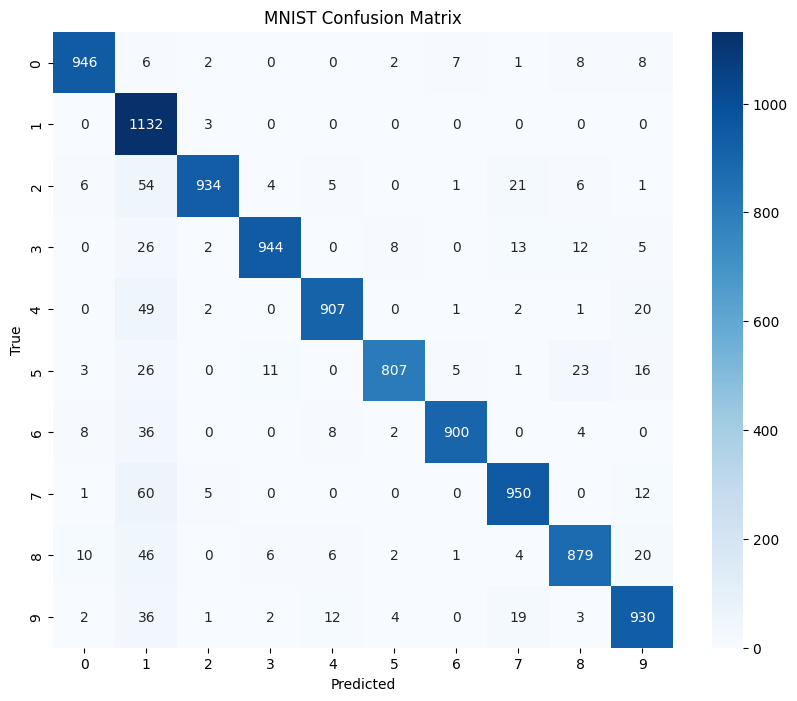

MNIST Analysis:
Accuracy: 0.9329
Most confusable pairs: [(1, 7, 60), (1, 2, 57), (1, 4, 49), (1, 8, 46), (1, 6, 36)]
Most discriminable digits: [1 0 6 3 7]
Most frequently guessed digits: [1 9 7 0 3]
Confusability scores: [(1, 0.3013215859030837), (9, 0.1595639246778989), (8, 0.15605749486652978), (7, 0.13521400778210116), (5, 0.11547085201793722), (2, 0.10949612403100775), (4, 0.1079429735234216), (3, 0.08811881188118811), (6, 0.07620041753653445), (0, 0.0653061224489796)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Partic

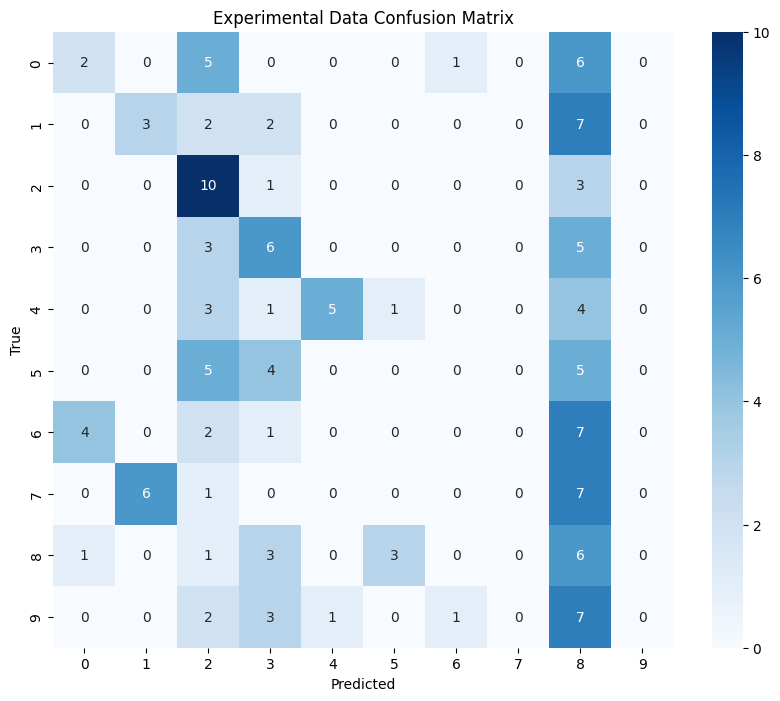


Experimental Data Analysis:
Accuracy: 0.22857142857142856
Most confusable pairs: [(3, 8, 8), (5, 8, 8), (0, 8, 7), (1, 8, 7), (6, 8, 7)]
Most discriminable digits: [2 8 3 4 1]
Most frequently guessed digits: [8 2 3 1 0]
Confusability scores: [(8, 4.214285714285714), (2, 2.0), (3, 1.6428571428571428), (5, 1.2857142857142858), (0, 1.2142857142857142), (1, 1.2142857142857142), (6, 1.1428571428571428), (7, 1.0), (9, 1.0), (4, 0.7142857142857143)]

Standard Composite Images Analysis:
Accuracy: 0.3500


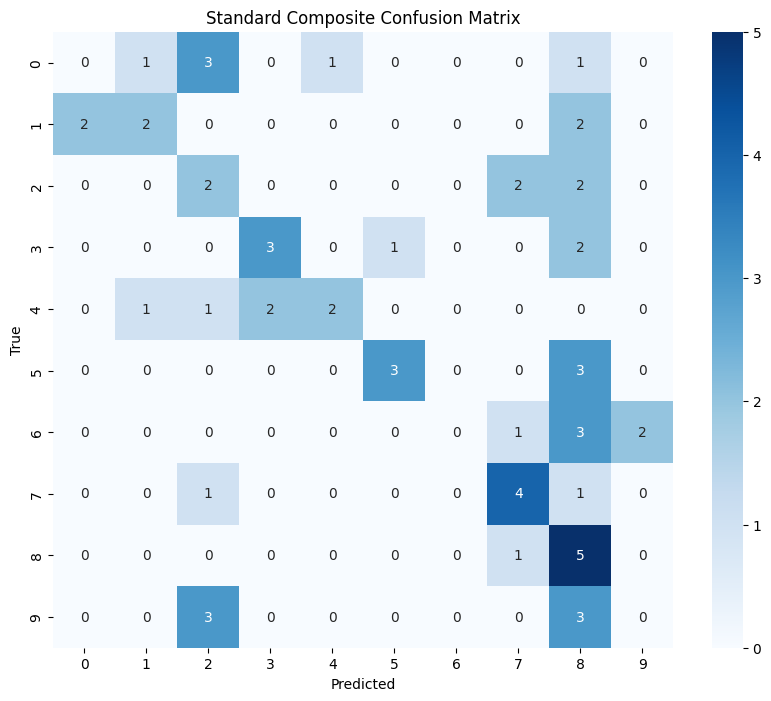

Confusability scores (digit: score):
  8: 3.0000
  2: 2.0000
  0: 1.3333
  9: 1.3333
  1: 1.0000
  6: 1.0000
  7: 1.0000
  3: 0.8333
  4: 0.8333
  5: 0.6667

Rotated Composite Images Analysis:
Accuracy: 0.1222


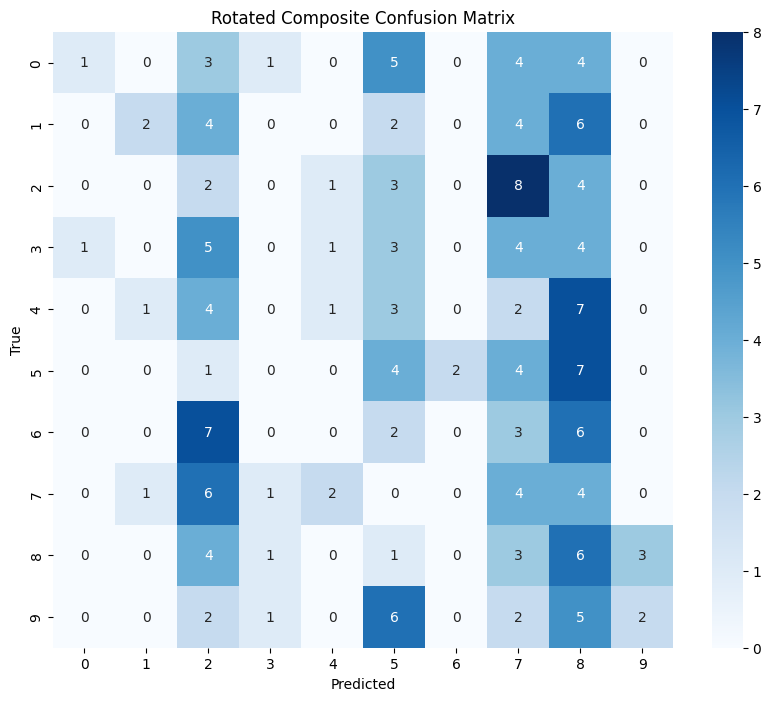

Confusability scores (digit: score):
  8: 3.2778
  2: 2.8889
  7: 2.6667
  5: 2.1667
  3: 1.2222
  4: 1.1667
  6: 1.1111
  9: 1.0556
  0: 1.0000
  1: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.3500


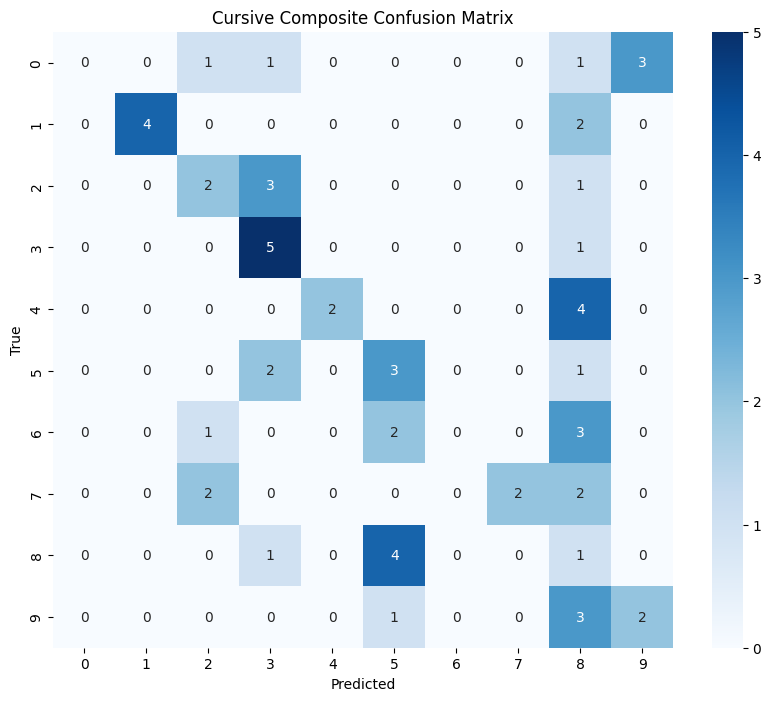

Confusability scores (digit: score):
  8: 3.8333
  5: 1.6667
  2: 1.3333
  3: 1.3333
  9: 1.1667
  0: 1.0000
  6: 1.0000
  4: 0.6667
  7: 0.6667
  1: 0.3333


In [7]:
# Cell 6: Run Evaluations
# Load the model
model_path = 'best_boi_models_finetuned_standard\ensemble_finetuned_noisy_mnist_balanced_0.5.pth'
model = load_ensemble(model_path).to(device)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

C:\Users\Sai\AppData\Local\Temp\ipykernel_40356\3548712547.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
C:\Users\Sai\AppData\Loca

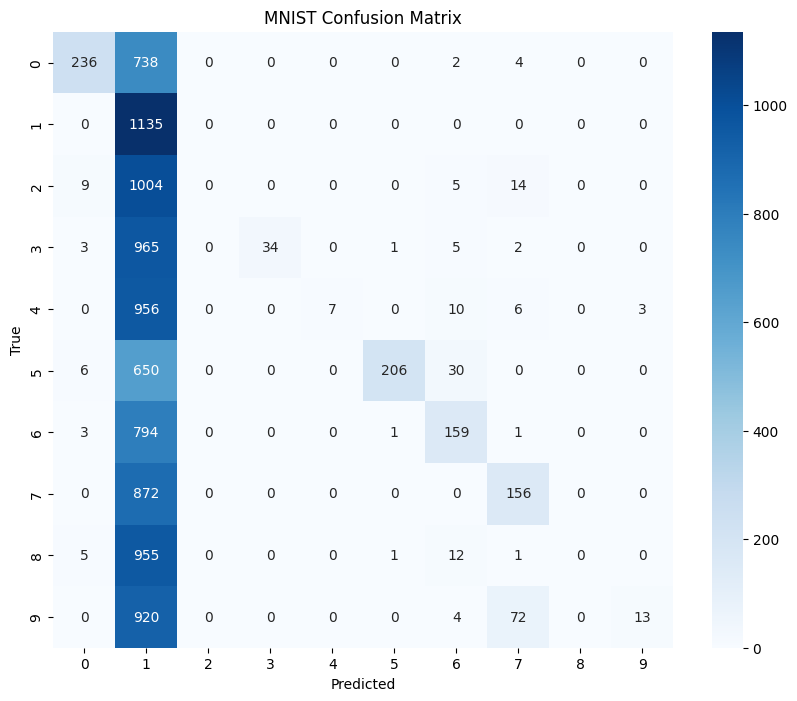

MNIST Analysis:
Accuracy: 0.1946
Most confusable pairs: [(1, 2, 1004), (1, 3, 965), (1, 4, 956), (1, 8, 955), (1, 9, 920)]
Most discriminable digits: [1 0 5 6 7]
Most frequently guessed digits: [1 0 7 6 5]
Confusability scores: [(1, 6.919823788546256), (2, 1.0), (8, 1.0), (4, 0.9928716904276986), (9, 0.9900891972249752), (3, 0.9663366336633663), (7, 0.9455252918287937), (6, 0.9050104384133612), (0, 0.7857142857142857), (5, 0.7724215246636771)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 10

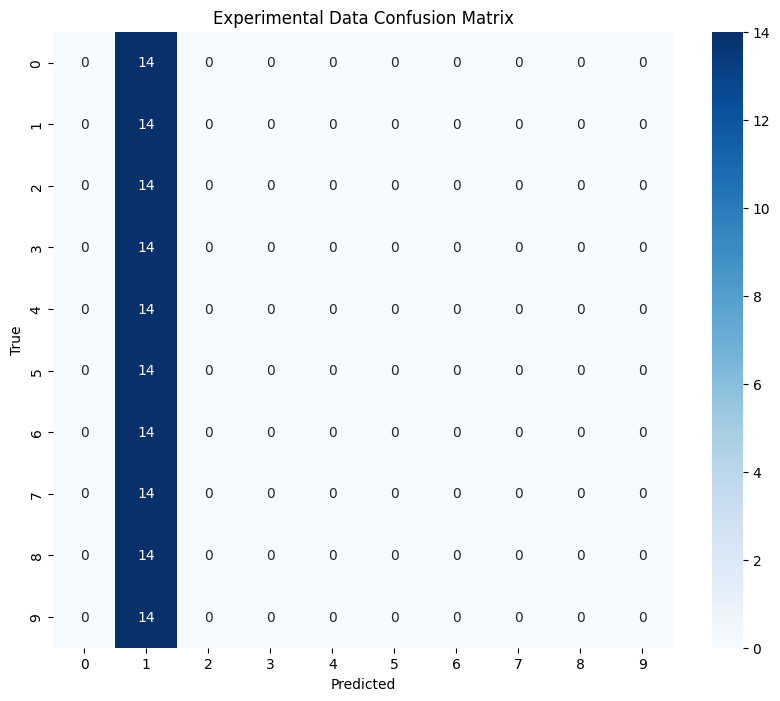


Experimental Data Analysis:
Accuracy: 0.1
Most confusable pairs: [(0, 1, 14), (1, 2, 14), (1, 3, 14), (1, 4, 14), (1, 5, 14)]
Most discriminable digits: [1 9 8 7 6]
Most frequently guessed digits: [1 9 8 7 6]
Confusability scores: [(1, 9.0), (0, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0)]

Standard Composite Images Analysis:
Accuracy: 0.1000


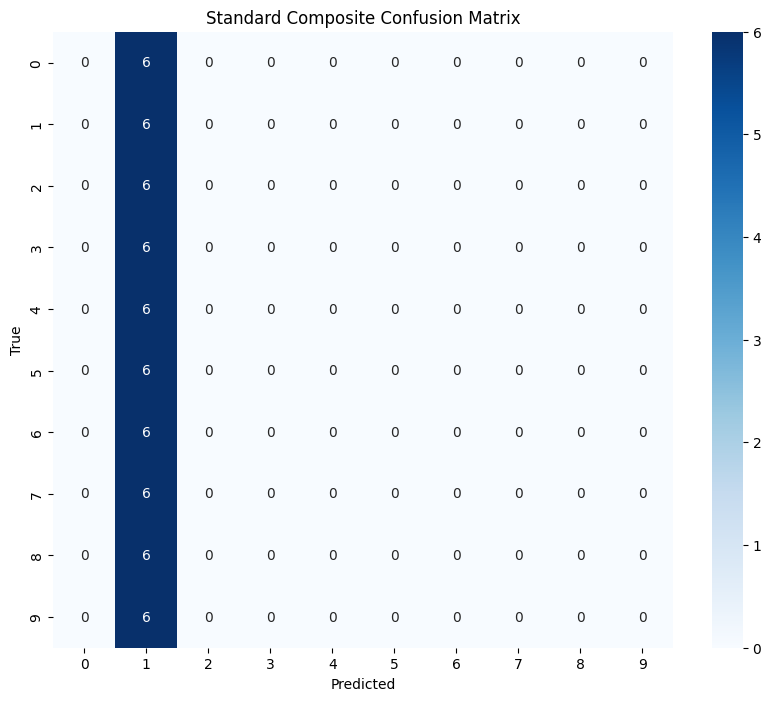

Confusability scores (digit: score):
  1: 9.0000
  0: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  8: 1.0000
  9: 1.0000

Rotated Composite Images Analysis:
Accuracy: 0.1000


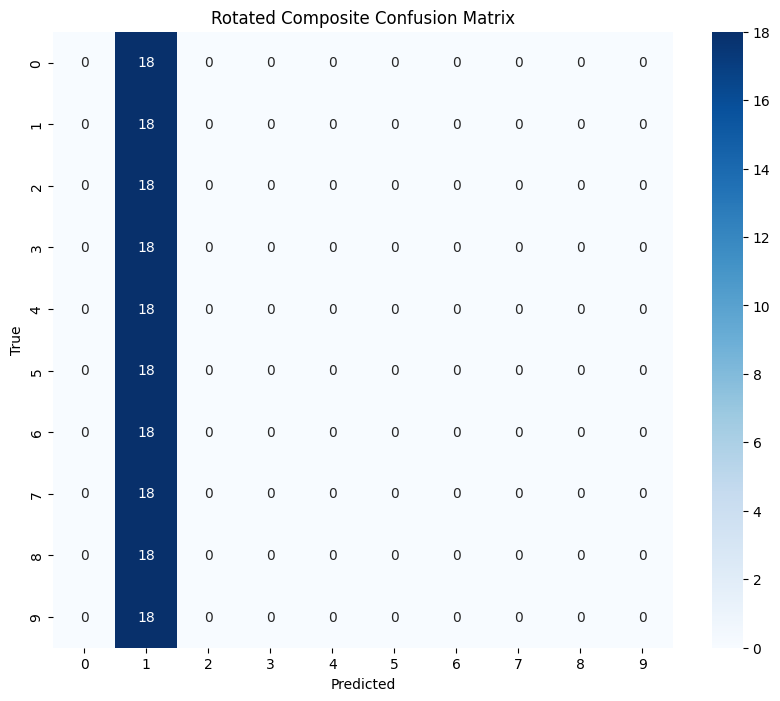

Confusability scores (digit: score):
  1: 9.0000
  0: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  8: 1.0000
  9: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.1000


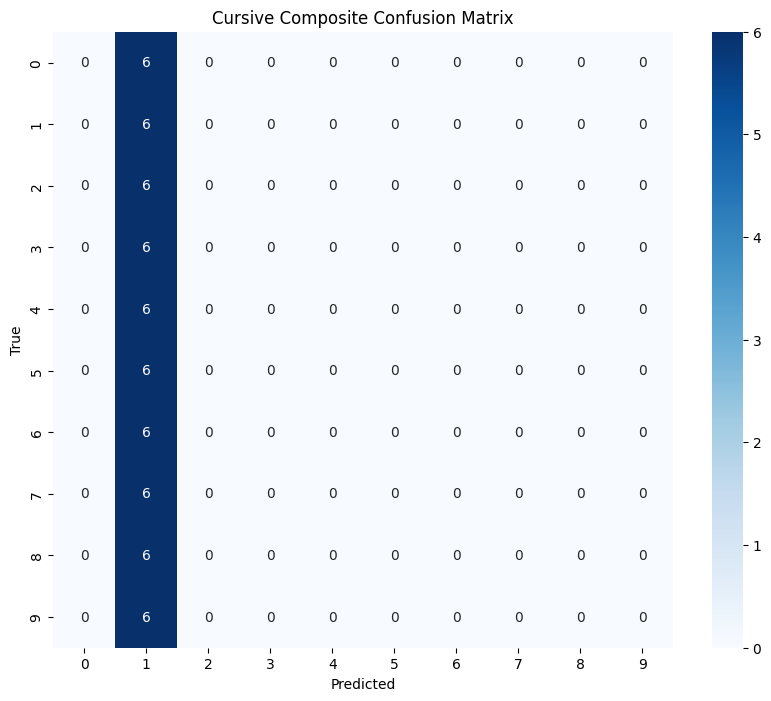

Confusability scores (digit: score):
  1: 9.0000
  0: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  8: 1.0000
  9: 1.0000


In [9]:
# Cell 6: Run Evaluations
# Load the model
model_path = 'best_boi_models_finetuned_standard\ensemble_finetuned_megaload.pth'
model = load_ensemble(model_path).to(device)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

C:\Users\Sai\AppData\Local\Temp\ipykernel_40356\3548712547.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
C:\Users\Sai\AppData\Loca

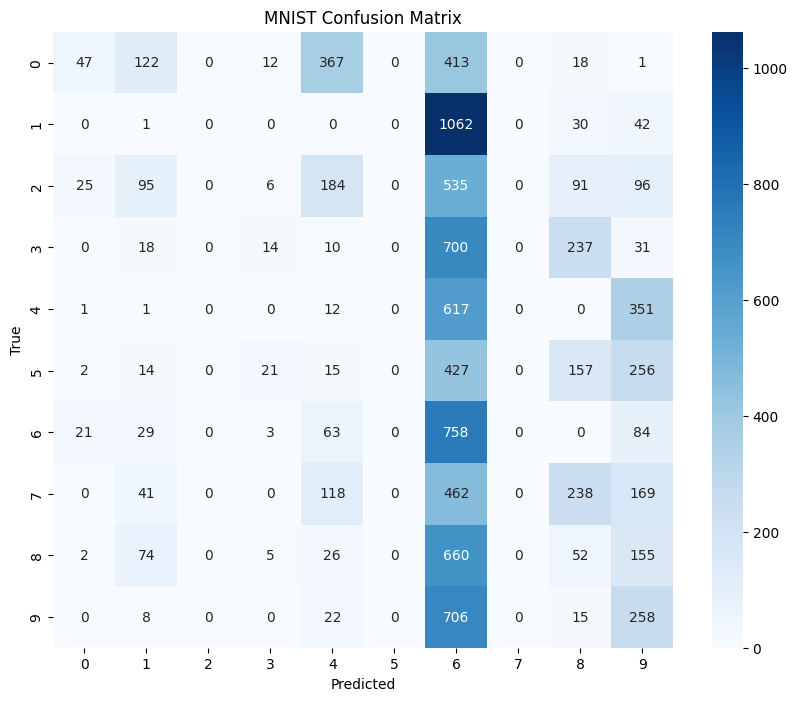

MNIST Analysis:
Accuracy: 0.1142
Most confusable pairs: [(1, 6, 1091), (6, 9, 790), (3, 6, 703), (4, 6, 680), (6, 8, 660)]
Most discriminable digits: [6 9 8 0 3]
Most frequently guessed digits: [6 9 8 4 1]
Confusability scores: [(6, 6.035490605427975), (9, 1.918731417244797), (4, 1.8075356415478616), (8, 1.7535934291581108), (1, 1.3533039647577092), (3, 1.0326732673267327), (0, 1.0040816326530613), (2, 1.0), (5, 1.0), (7, 1.0)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images

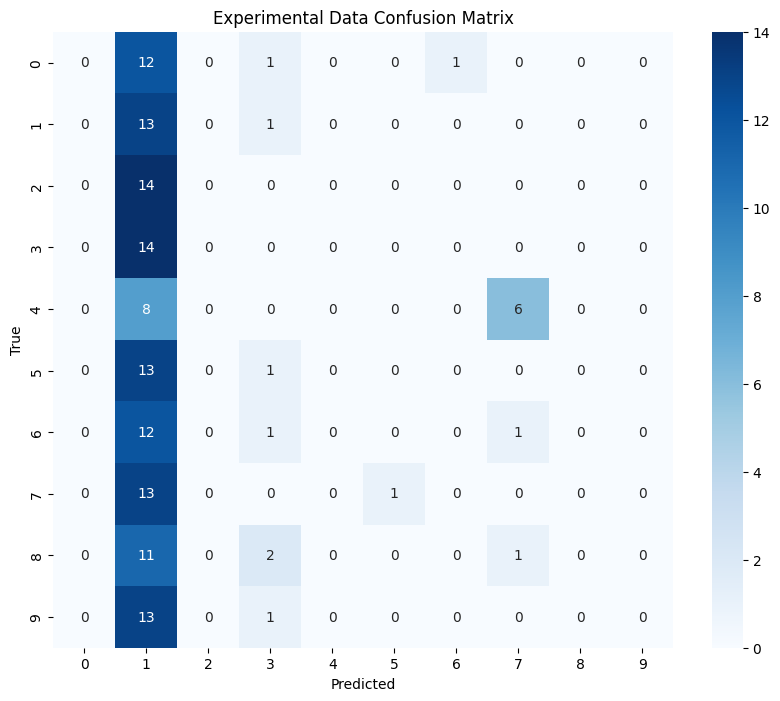


Experimental Data Analysis:
Accuracy: 0.09285714285714286
Most confusable pairs: [(1, 3, 15), (1, 2, 14), (1, 5, 13), (1, 7, 13), (1, 9, 13)]
Most discriminable digits: [1 9 8 7 6]
Most frequently guessed digits: [1 7 3 6 5]
Confusability scores: [(1, 7.928571428571429), (7, 1.5714285714285714), (3, 1.5), (5, 1.0714285714285714), (6, 1.0714285714285714), (0, 1.0), (2, 1.0), (4, 1.0), (8, 1.0), (9, 1.0)]

Standard Composite Images Analysis:
Accuracy: 0.1333


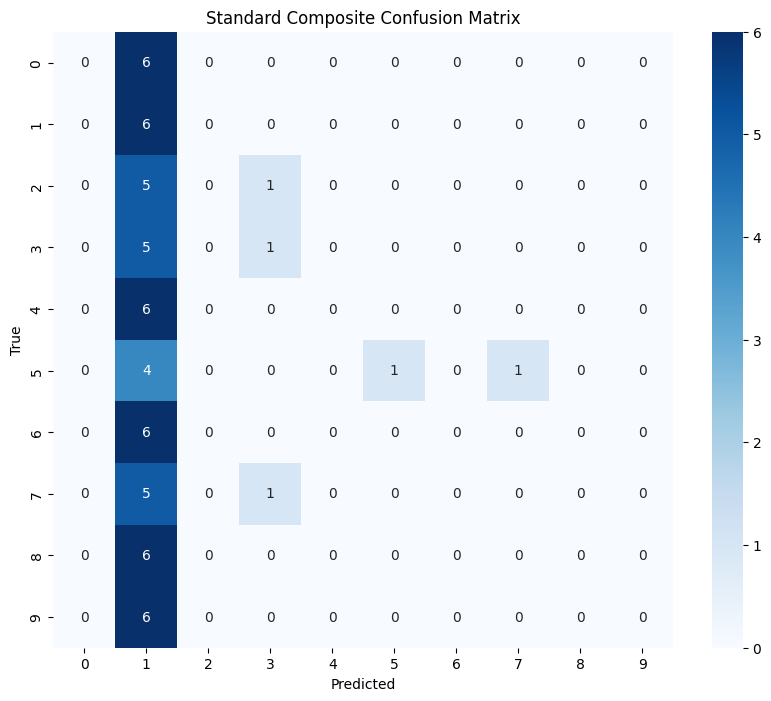

Confusability scores (digit: score):
  1: 8.1667
  3: 1.1667
  7: 1.1667
  0: 1.0000
  2: 1.0000
  4: 1.0000
  6: 1.0000
  8: 1.0000
  9: 1.0000
  5: 0.8333

Rotated Composite Images Analysis:
Accuracy: 0.1333


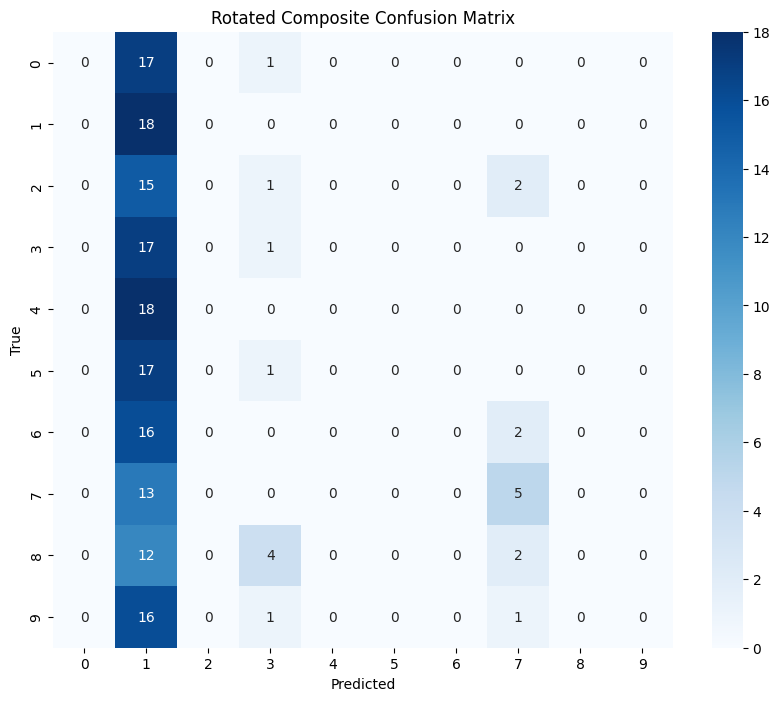

Confusability scores (digit: score):
  1: 7.8333
  3: 1.3889
  7: 1.1111
  0: 1.0000
  2: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  8: 1.0000
  9: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.1167


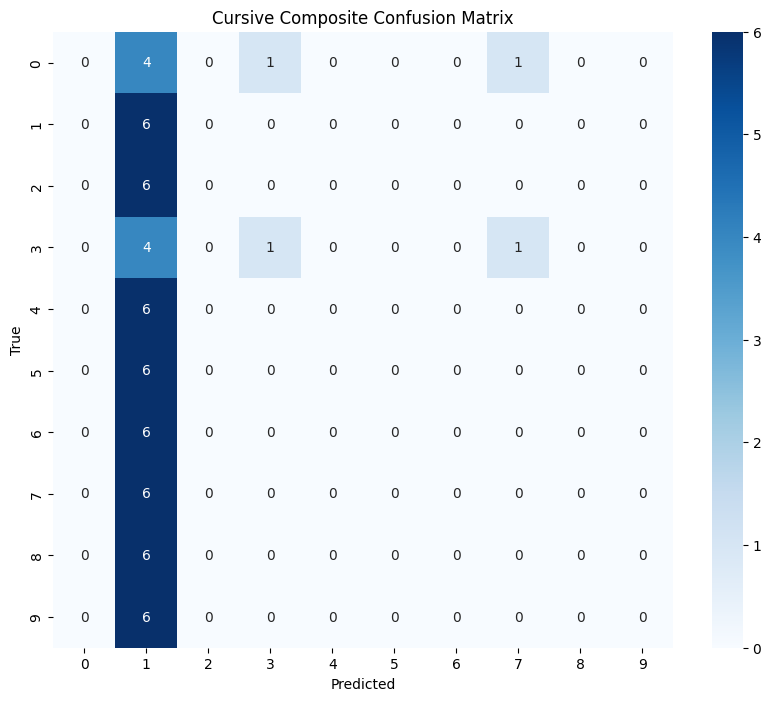

Confusability scores (digit: score):
  1: 8.3333
  7: 1.3333
  0: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  8: 1.0000
  9: 1.0000


In [10]:
 # Cell 6: Run Evaluations
# Load the model
model_path = 'best_boi_models_finetuned_advanced\ensemble_finetuned_megaload2.pth'
model = load_ensemble(model_path).to(device)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

C:\Users\Sai\AppData\Local\Temp\ipykernel_42256\3548712547.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
C:\Users\Sai\AppData\Loca

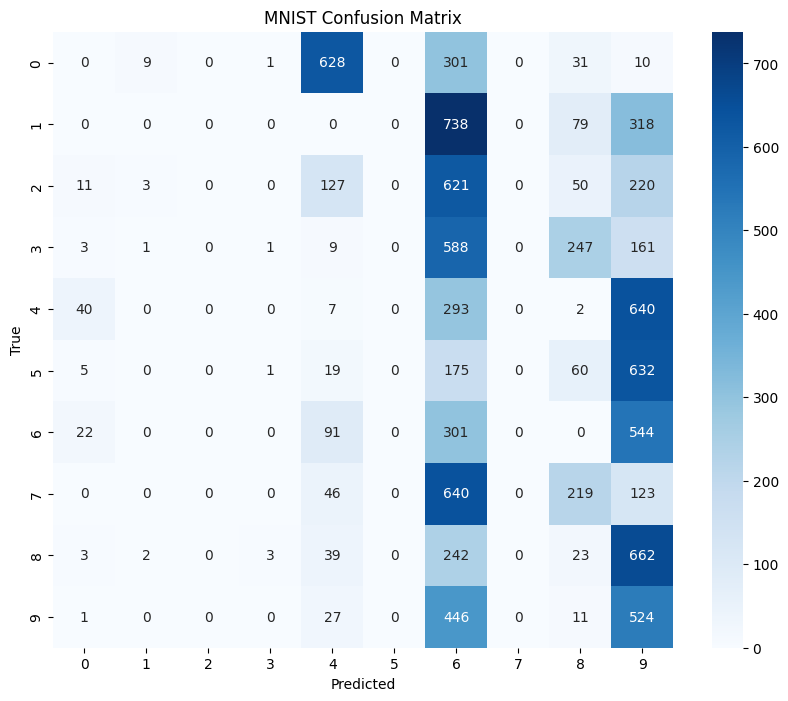

MNIST Analysis:
Accuracy: 0.0856
Most confusable pairs: [(6, 9, 990), (1, 6, 738), (8, 9, 673), (0, 4, 668), (4, 9, 667)]
Most discriminable digits: [9 6 8 4 3]
Most frequently guessed digits: [6 9 4 8 0]
Confusability scores: [(6, 4.907098121085595), (9, 3.761149653121903), (4, 1.9969450101832993), (8, 1.6940451745379876), (0, 1.086734693877551), (1, 1.013215859030837), (3, 1.003960396039604), (2, 1.0), (5, 1.0), (7, 1.0)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10

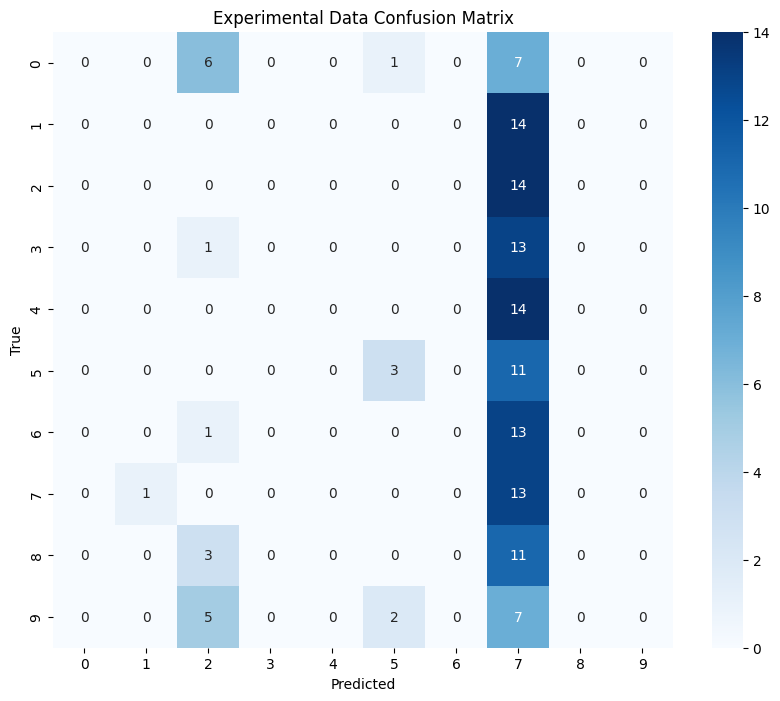


Experimental Data Analysis:
Accuracy: 0.11428571428571428
Most confusable pairs: [(1, 7, 15), (2, 7, 14), (4, 7, 14), (3, 7, 13), (6, 7, 13)]
Most discriminable digits: [7 5 9 8 6]
Most frequently guessed digits: [7 2 5 1 9]
Confusability scores: [(7, 7.5), (2, 2.142857142857143), (1, 1.0714285714285714), (0, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (8, 1.0), (9, 1.0)]

Standard Composite Images Analysis:
Accuracy: 0.2333


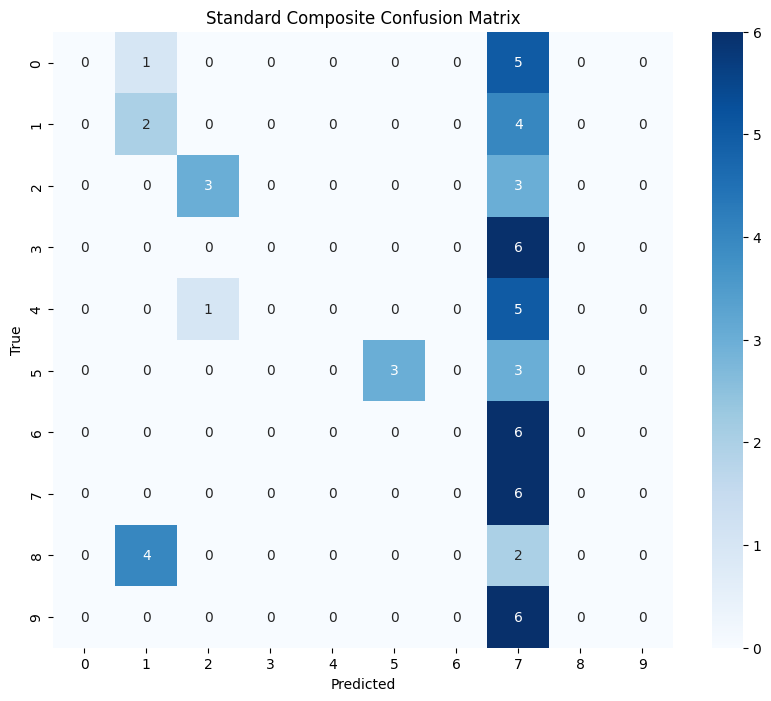

Confusability scores (digit: score):
  7: 6.6667
  1: 1.5000
  0: 1.0000
  3: 1.0000
  4: 1.0000
  6: 1.0000
  8: 1.0000
  9: 1.0000
  2: 0.6667
  5: 0.5000

Rotated Composite Images Analysis:
Accuracy: 0.3889


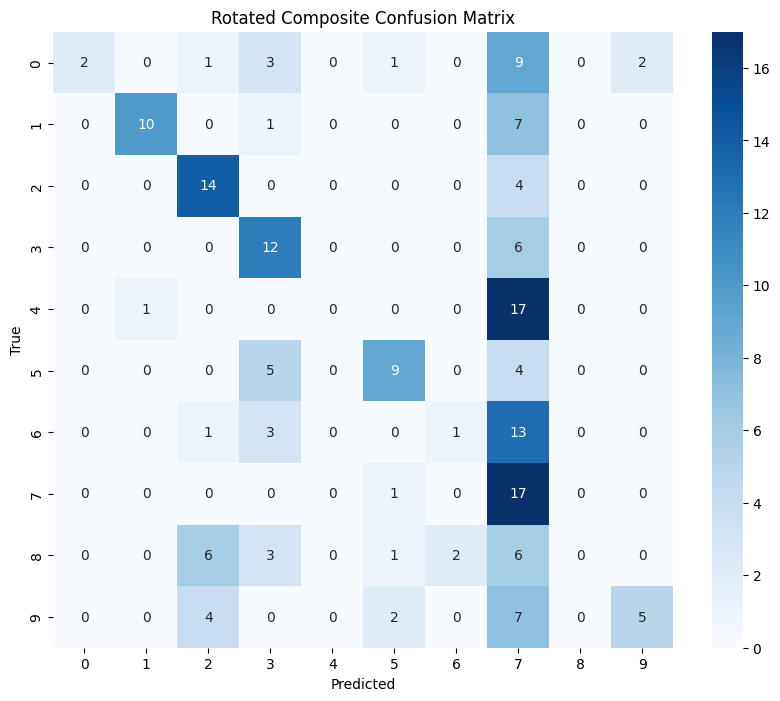

Confusability scores (digit: score):
  7: 4.1111
  3: 1.1667
  6: 1.0556
  4: 1.0000
  8: 1.0000
  0: 0.8889
  2: 0.8889
  9: 0.8333
  5: 0.7778
  1: 0.5000

Cursive Composite Images Analysis:
Accuracy: 0.1333


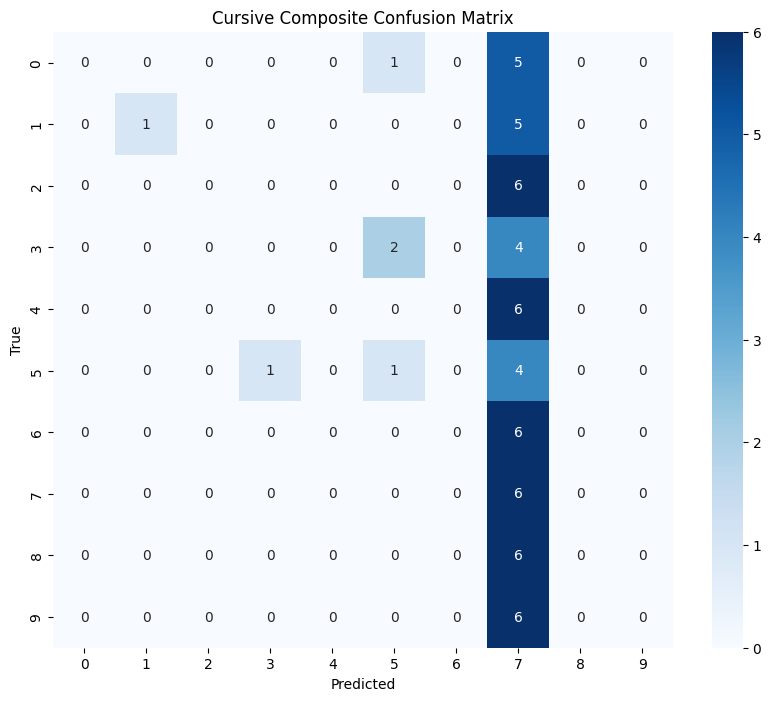

Confusability scores (digit: score):
  7: 8.0000
  5: 1.3333
  3: 1.1667
  0: 1.0000
  2: 1.0000
  4: 1.0000
  6: 1.0000
  8: 1.0000
  9: 1.0000
  1: 0.8333


In [6]:
 # Cell 6: Run Evaluations
# Load the model
model_path = 'best_boi_models_finetuned_advanced\ensemble_finetuned_megaload3.pth'
model = load_ensemble(model_path).to(device)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet50_model():
    model = models.resnet50(pretrained=False)  # Set to False since we're loading our own weights
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Create the model with the same architecture as during training
model = create_resnet50_model()

# Load the state dictionary
state_dict = torch.load('resnet50_mnist_experiment.pth')
model.load_state_dict(state_dict)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Sai\AppData\Local\Temp\ipykernel_42256\2013999643.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untru

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

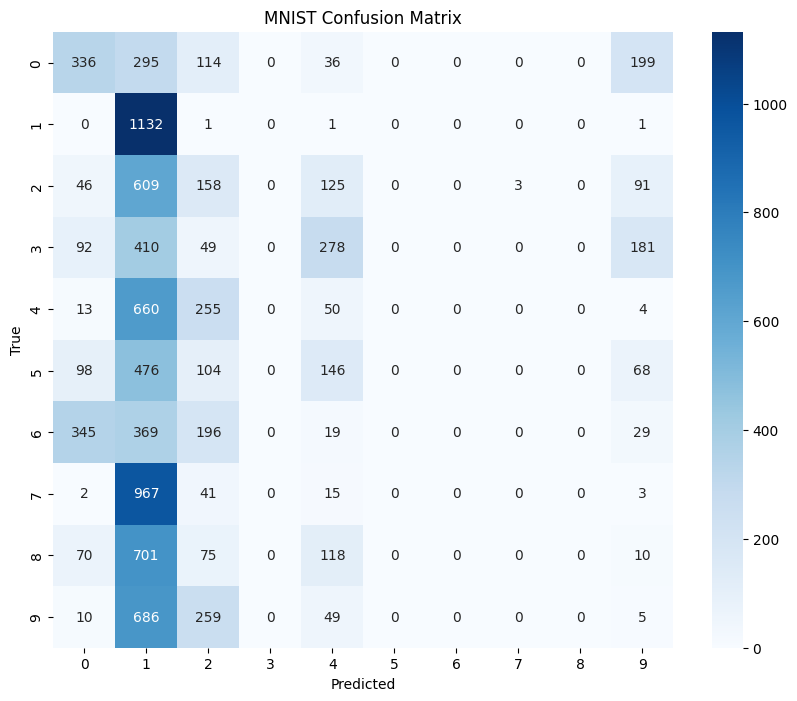

MNIST Analysis:
Accuracy: 0.1681
Most confusable pairs: [(1, 7, 967), (1, 8, 701), (1, 9, 687), (1, 4, 661), (1, 2, 610)]
Most discriminable digits: [1 0 2 4 9]
Most frequently guessed digits: [1 2 0 4 9]
Confusability scores: [(1, 4.5603524229074885), (2, 1.9069767441860466), (4, 1.7505091649694502), (9, 1.5758176412289395), (0, 1.346938775510204), (7, 1.0029182879377432), (3, 1.0), (5, 1.0), (6, 1.0), (8, 1.0)]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participan

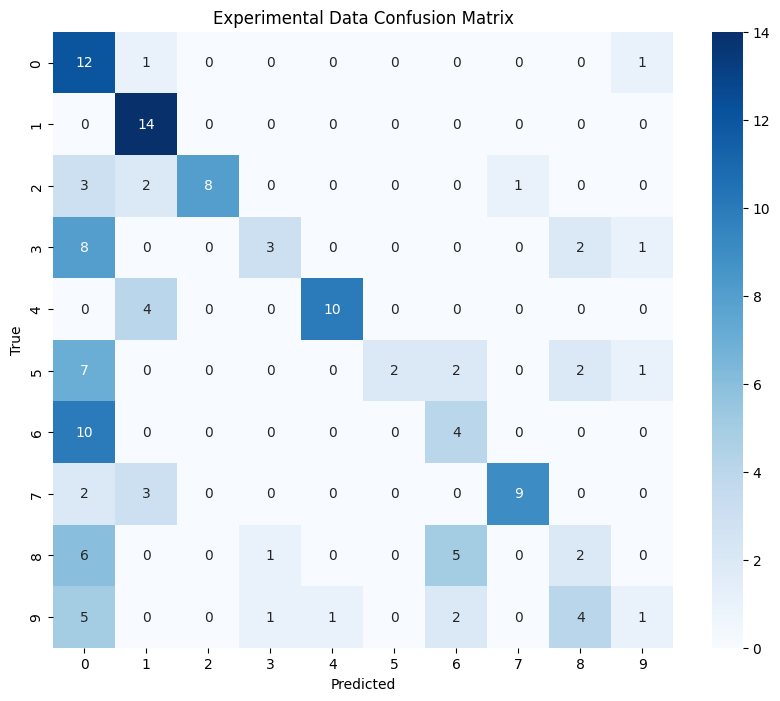


Experimental Data Analysis:
Accuracy: 0.4642857142857143
Most confusable pairs: [(0, 6, 10), (0, 3, 8), (0, 5, 7), (0, 8, 6), (0, 9, 6)]
Most discriminable digits: [1 0 4 7 2]
Most frequently guessed digits: [0 1 6 4 8]
Confusability scores: [(0, 3.0714285714285716), (8, 1.4285714285714286), (6, 1.3571428571428572), (9, 1.1428571428571428), (3, 0.9285714285714286), (5, 0.8571428571428571), (1, 0.7142857142857143), (2, 0.42857142857142855), (7, 0.42857142857142855), (4, 0.35714285714285715)]

Standard Composite Images Analysis:
Accuracy: 0.1667


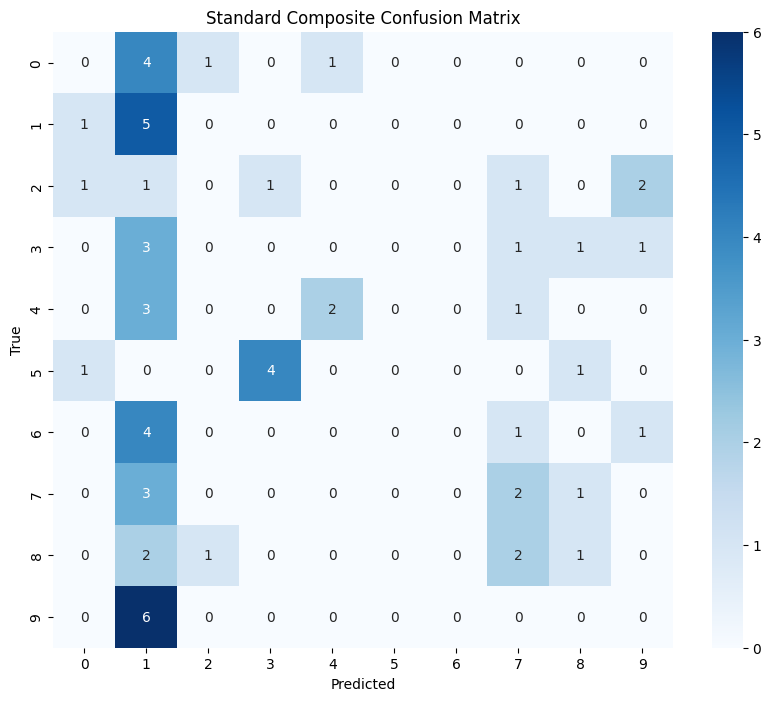

Confusability scores (digit: score):
  1: 4.5000
  3: 1.8333
  7: 1.6667
  9: 1.6667
  0: 1.5000
  2: 1.3333
  8: 1.3333
  5: 1.0000
  6: 1.0000
  4: 0.8333

Rotated Composite Images Analysis:
Accuracy: 0.1222


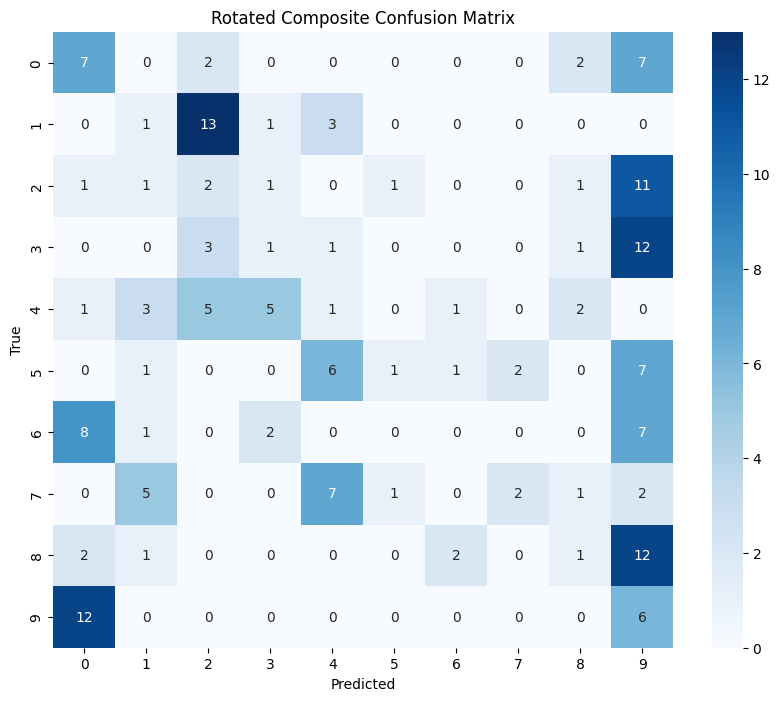

Confusability scores (digit: score):
  9: 3.8889
  2: 2.1667
  0: 1.9444
  4: 1.8889
  1: 1.6111
  3: 1.4444
  8: 1.3333
  6: 1.2222
  5: 1.0556
  7: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.3000


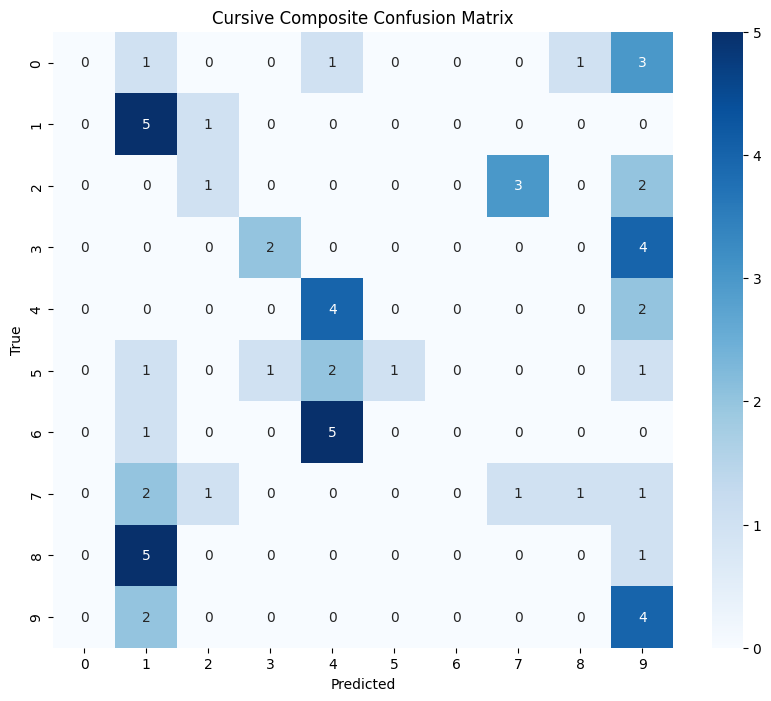

Confusability scores (digit: score):
  9: 2.6667
  1: 2.1667
  4: 1.6667
  7: 1.3333
  8: 1.3333
  2: 1.1667
  0: 1.0000
  6: 1.0000
  3: 0.8333
  5: 0.8333


In [10]:
# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

In [6]:
# Function to invert the MNIST images (black digits on white background)
def invert_image(image):
    return 1 - image

# Cell 3: Data Loading Functions
def load_mnist_test_data():
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        #transforms.Lambda(invert_image)  # Use invert_image function instead of lambda
    ])
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\saith\AppData\Local\Temp\ipykernel_24716\1571636764.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=to

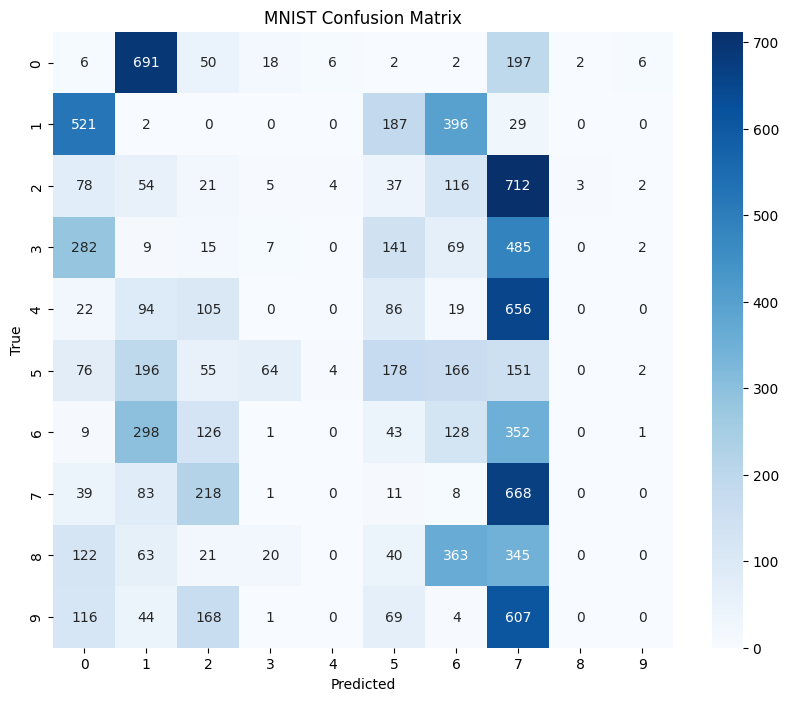

MNIST Analysis:
Accuracy: 0.101
Most confusable pairs: [(0, 1, 1212), (2, 7, 930), (1, 6, 694), (4, 7, 656), (7, 9, 607)]
Most discriminable digits: [7 5 6 2 3]
Most frequently guessed digits: [7 1 6 0 5]
Confusability scores: [(7, 3.7879377431906613), (1, 2.3480176211453743), (0, 2.2846938775510206), (6, 2.059498956158664), (2, 1.7141472868217054), (5, 1.4910313901345291), (3, 1.101980198019802), (4, 1.0142566191446027), (9, 1.0128840436075321), (8, 1.0051334702258727)]
Total training images: 34000
Total test images: 190
Participant 2:
  Training images: 1000
  Test images: 10
Participant 4:
  Training images: 1000
  Test images: 10
Participant 14:
  Training images: 500
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant

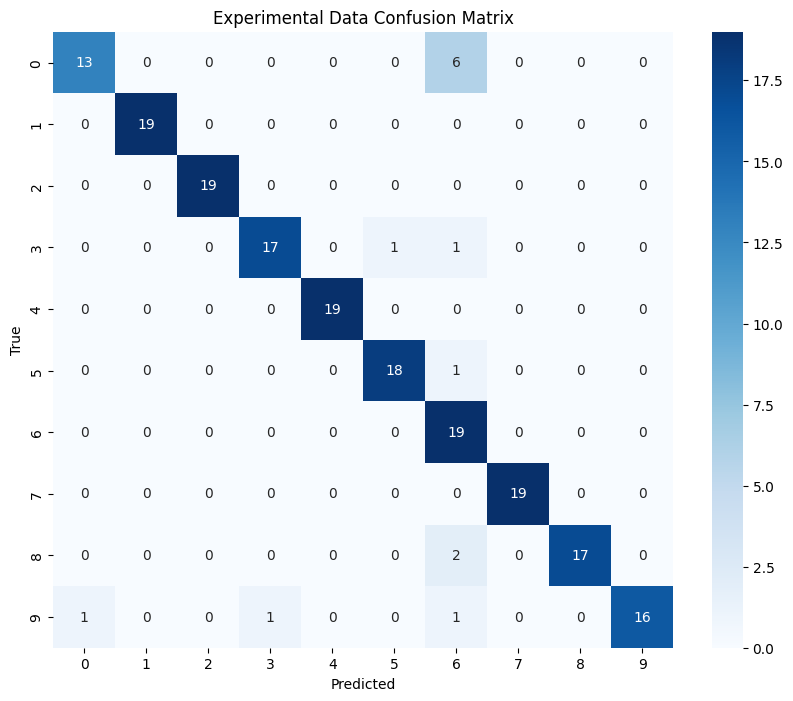


Experimental Data Analysis:
Accuracy: 0.9263157894736842
Most confusable pairs: [(0, 6, 6), (6, 8, 2), (0, 9, 1), (3, 5, 1), (3, 6, 1)]
Most discriminable digits: [7 6 4 2 1]
Most frequently guessed digits: [6 7 5 4 2]
Confusability scores: [(6, 0.5789473684210527), (0, 0.3684210526315789), (3, 0.15789473684210525), (9, 0.15789473684210525), (5, 0.10526315789473684), (8, 0.10526315789473684), (1, 0.0), (2, 0.0), (4, 0.0), (7, 0.0)]


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'composite_image_folders'

In [7]:
# Function to create LeNet5 model for MNIST-like grayscale images
class LeNet5_16x16(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5_16x16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Adjusted for 16x16 input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Function to load LeNet5 model for 16x16 images with pre-trained weights
def load_lenet5_model_16x16(file_path=None):
    model = LeNet5_16x16(num_classes=10)
    if file_path:
        model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))  # Load pre-trained weights to CPU
    return model

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the appropriate device
model = load_lenet5_model_16x16('lenet5_trained_model.pth')
model = model.to(device)

# Modify the evaluate_model function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

In [ ]:
# Function to create LeNet5 model for MNIST-like grayscale images
class LeNet5_16x16(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5_16x16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Adjusted for 16x16 input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Function to load LeNet5 model for 16x16 images with pre-trained weights
def load_lenet5_model_16x16(file_path=None):
    model = LeNet5_16x16(num_classes=10)
    if file_path:
        model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))  # Load pre-trained weights to CPU
    return model

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the appropriate device
model = load_lenet5_model_16x16('lenet5_trained_model1.pth')
model = model.to(device)

# Modify the evaluate_model function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)

C:\Users\Sai\AppData\Local\Temp\ipykernel_138116\143283960.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=torc

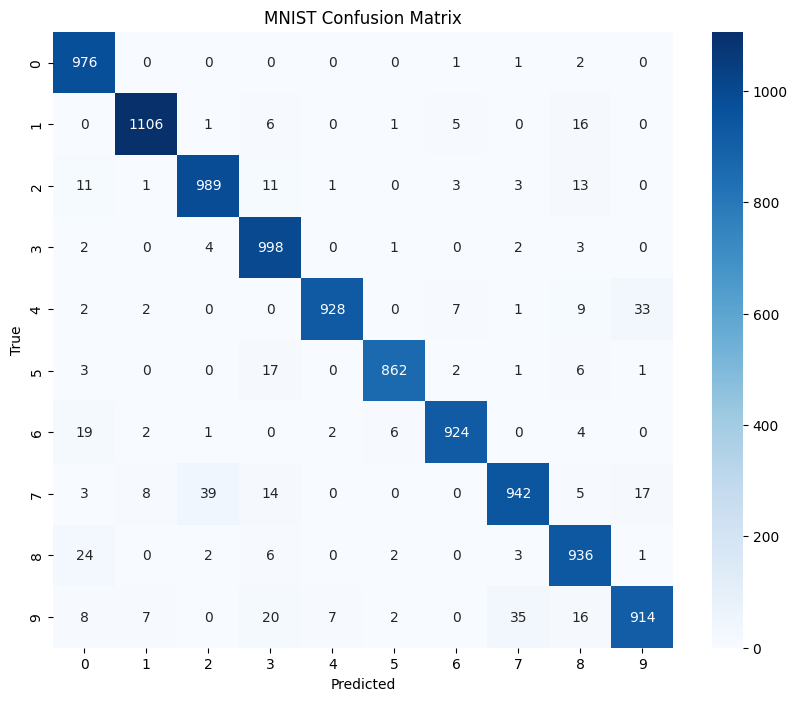

MNIST Analysis:
Accuracy: 0.9575
Most confusable pairs: [(7, 9, 52), (2, 7, 42), (4, 9, 40), (0, 8, 26), (0, 6, 20)]
Most discriminable digits: [0 3 1 5 6]
Most frequently guessed digits: [1 3 0 2 8]
Confusability scores: [(9, 0.14568880079286423), (7, 0.12840466926070038), (8, 0.11498973305954825), (2, 0.0872093023255814), (3, 0.08514851485148515), (0, 0.07755102040816327), (4, 0.06517311608961303), (6, 0.054279749478079335), (5, 0.04708520179372197), (1, 0.04317180616740088)]
Total training images: 34000
Total test images: 190
Participant 2:
  Training images: 1000
  Test images: 10
Participant 4:
  Training images: 1000
  Test images: 10
Participant 14:
  Training images: 500
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Part

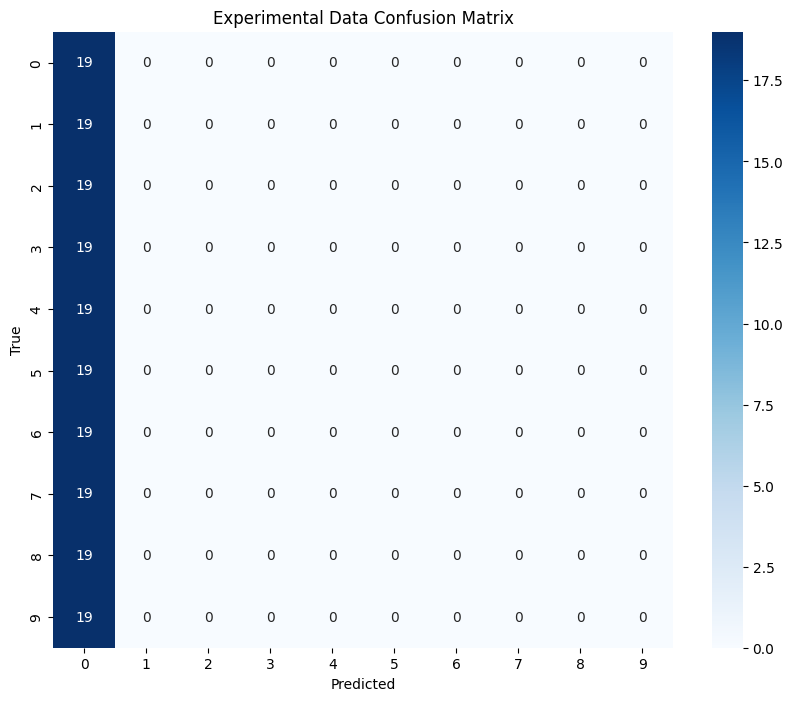


Experimental Data Analysis:
Accuracy: 0.1
Most confusable pairs: [(0, 1, 19), (0, 2, 19), (0, 3, 19), (0, 4, 19), (0, 5, 19)]
Most discriminable digits: [0 9 8 7 6]
Most frequently guessed digits: [0 9 8 7 6]
Confusability scores: [(0, 9.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0)]

Standard Composite Images Analysis:
Accuracy: 0.1000


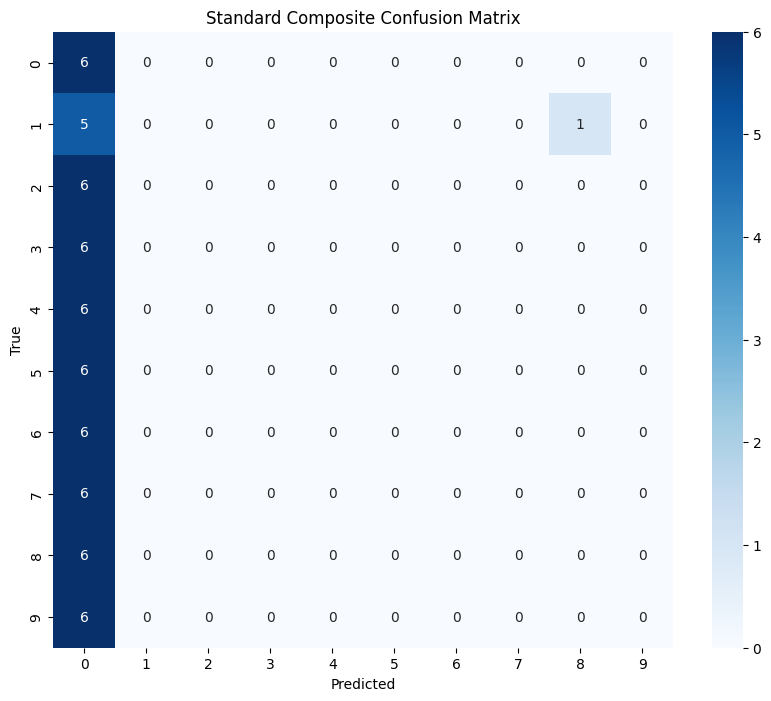

Confusability scores (digit: score):
  0: 8.8333
  8: 1.1667
  1: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  9: 1.0000

Rotated Composite Images Analysis:
Accuracy: 0.0944


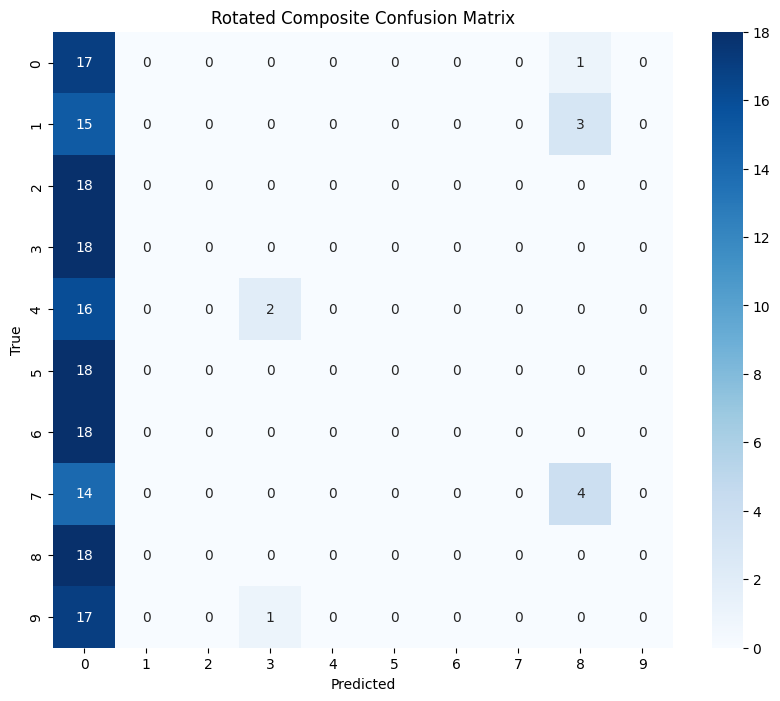

Confusability scores (digit: score):
  0: 8.5000
  8: 1.4444
  3: 1.1667
  1: 1.0000
  2: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  9: 1.0000

Cursive Composite Images Analysis:
Accuracy: 0.1000


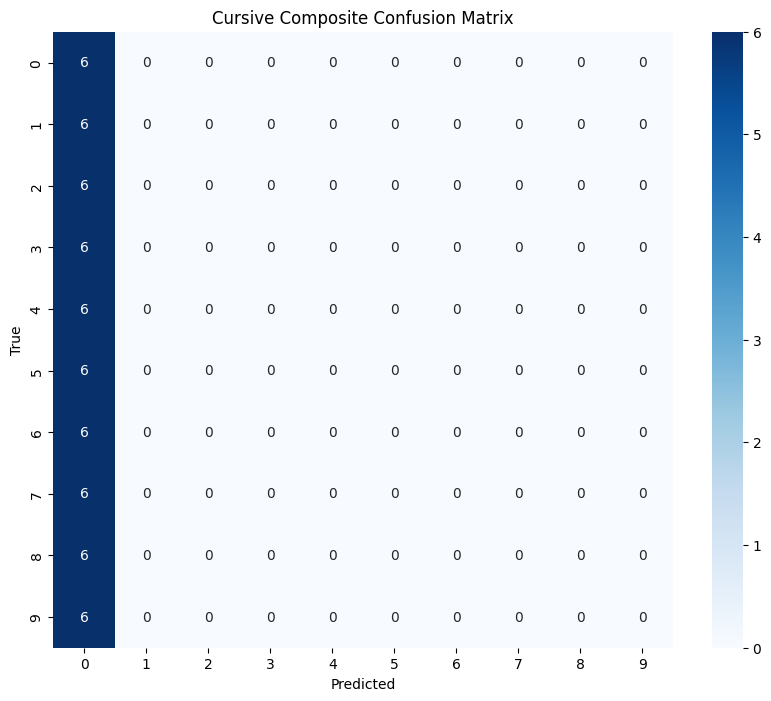

Confusability scores (digit: score):
  0: 9.0000
  1: 1.0000
  2: 1.0000
  3: 1.0000
  4: 1.0000
  5: 1.0000
  6: 1.0000
  7: 1.0000
  8: 1.0000
  9: 1.0000


In [15]:
# Function to create LeNet5 model for MNIST-like grayscale images
class LeNet5_16x16(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5_16x16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Adjusted for 16x16 input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Function to load LeNet5 model for 16x16 images with pre-trained weights
def load_lenet5_model_16x16(file_path=None):
    model = LeNet5_16x16(num_classes=10)
    if file_path:
        model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))  # Load pre-trained weights to CPU
    return model

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the appropriate device
model = load_lenet5_model_16x16('best_model.pth')
model = model.to(device)

# Modify the evaluate_model function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Run main evaluation
main_evaluation(model)

# Run composite evaluation
analyze_composite_data(model, base_folder)